## Cuisine Exploration Notebook 
This notebook is a continuation of the restaurant recommender project. It is meant to run after the creation of the working dataset - the aggregation and cleaning of four different datasets found on kaggle.  
The goal of this notebook is to look into the cuisine types listed - each restaurant has a list of cuisines associated with it. 

The aim is to answer these questions: 
1. what are these cuisines?
2. how can they be used as categories? - this will be helpful both for more accurate recommendations, and for better Ml results in the next step (providing a best-guess of the items on the menu based on the cuisine type)
3. improving the existing cuisine categorization: making generic categories more accurate, selecting best labels out of longer lists      

main tools used: 
- gensim implementation of word2vec 
- logistic regression

- The issue with the constructed dataset is that the categorization can be somewhat unreliable - a restaurant could be listed as 2 or more categories for marketing purposes, of which only one or two are actually relevant for our use. Without creating a manually-tagged dataset, honing in on the accurate cuisine categories falls somewhere between supervised and unsupervised learning. As such, the training was broken into two steps: 
1. closer to supervised learning - only menus that have a single cuisine listed will be used to train the model. 
2. closer to unsupervised learning - menus that have more than a single cuisine listed will be used for training, trying to find a point where the model covers enough of the rows in the full dataset while being human-understandable.    

In [1]:
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from gensim.matutils import veclen
from pandas.errors import SettingWithCopyWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns
from itertools import combinations

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [2]:
full_combo = pd.read_csv("full_combo.csv")
full_combo["ZipCode"].astype(int)
full_combo["Raw Items"] = full_combo["Items"]
full_combo["Raw Cuisines"] = full_combo["Cuisine"]
list_columns = ["Popular Foods", "Items", "Cuisine"]
for column in list_columns:
    full_combo[column] = full_combo[column].apply(lambda s: s.split(", ") if isinstance(s, str) else s)
full_combo.drop_duplicates(["Name", "ZipCode"], inplace=True)
full_combo

,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Inspection Date,Inspection Grade,Inspection Critical,Cuisine,Address,grade and rating,items with no cuisine,cuisine with no items,Raw Items,Raw Cuisines
0,218,10013,4.2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"218 Grand St, New York, 10013",False,False,False,NaN,NaN
1,251 Ginza Sushi,10016,NaN,NaN,NaN,NaN,"[soda, spring water and soda, snapple ice tea,...",NaN,NaN,NaN,"[japanese, sushi]","251 E 35th St, New York, 10016",False,False,False,"soda, spring water and soda, snapple ice tea, ...","japanese, sushi"
2,3 Guys Restaurant,10021,NaN,NaN,“Quick lunch and good service”,NaN,"[cold cereal, cold cereal with banana, hot oat...",NaN,NaN,NaN,"[cafe, japanese, american, diner]","960 Madison Ave, New York, 10021",False,False,False,"cold cereal, cold cereal with banana, hot oatm...","cafe, japanese, american, diner"
3,4 Caminos Mexican Restaurant,11385,4.1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"67-22 Fresh Pond Rd, Queens, 11385",False,False,False,NaN,NaN
4,5 Brothers Gourmet Deli,10036,NaN,NaN,NaN,NaN,"[fresh homemade beef brisket sandwich, fresh t...",NaN,NaN,NaN,"[sandwiches, deli food, american, burgers]","689 10th Ave, New York, 10036",False,False,False,"fresh homemade beef brisket sandwich, fresh to...","sandwiches, deli food, american, burgers"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,ilili Restaurant,10001,4.5,3.0,NaN,NaN,"[lunch prix fixe special, falafel wrap, grille...",NaN,NaN,NaN,"[middle eastern, mediterranean, tapas]","236 5th Ave, New York, 10001",False,False,False,"lunch prix fixe special, falafel wrap, grilled...","middle eastern, mediterranean, tapas"
800,taïm mediterranean kitchen,10038,4.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"75 Maiden Ln, New York, 10038",False,False,False,NaN,NaN
801,არგო,11223,4.6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1985 Coney Island Ave, Brooklyn, 11223",False,False,False,NaN,NaN
802,უბანი,11209,4.7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Georgian Cuisine, 8309 3rd Ave, 11209",False,False,False,NaN,NaN


In [3]:
## for the purposes of this section, only rows with items are relevant - since the goal here is (item list -> specific cuisine)
full_combo["Valid Items"] = full_combo["Items"].apply(lambda x: isinstance(x, list))
full_combo = full_combo[full_combo["Valid Items"]]
len(full_combo)

519

#### extracting cuisine (basic) 
from restaurant name and review comment

In [4]:
cuisines = []
for line in full_combo["Cuisine"]:
    if isinstance(line, list):
        for cuisine in line:
            if cuisine not in cuisines:
                cuisines.append(cuisine.lower())
# cuisines 

In [5]:
def find_cuisines(name):
    cuisines_in_name = []
    if isinstance(name, str):
        for word in name.lower().split():
            if word in cuisines:
                cuisines_in_name.append(word.title())
    return cuisines_in_name

In [6]:
full_combo["Cuisine"] = full_combo.apply(
    lambda row: row["Cuisine"] if isinstance(row["Cuisine"], list) else find_cuisines(row["Name"]), axis=1)
full_combo["Cuisine"] = full_combo.apply(
    lambda row: row["Cuisine"] if isinstance(row["Cuisine"], list) else find_cuisines(row["Review Comment"]), axis=1)

# note: it can be assumed that the name of a restaurant will contain the cuisine name only if it is relevant - i.e., one would expect "John's Chinese Place" (serving Chinese cuisine) but not "John's not Korean Place" (serving Chinese cuisine). In contrast, such an assumption cannot be made about a review comment - the reviewer may have been under a false impression of the cuisine that should be expected, and this could be mentioned in their review (e.g. "If this place claimed to be Elvish, these sour sauces would make sense!") - resulting in some inaccuracies. Since this dataset is a little small and isn't 100% full of the data desired, and as this is, after all, just an exercise with what is essentially dummy data, this use was left in. In production, in real-world cases, a more complex approach would be required to ensure the extraction is accurate.  

#### cleaning common naming issues 

In [7]:
## in order to clean up the cuisine names, several actions are taken here: :
# cleaning "&", removing the stopword "food", remove meaningless cuisines, merge all the cafe categories
# as well as differentiating between american cuisine and south-/latin-american cuisine by treating "american" as a stopword in those cases only. 
def clean_cuisine(s):
    clean = s.lower().replace("&", "").strip() #replace(" food", "").
    # if "american" in clean:
    #     if clean != "american":  
    #         clean= " ".join([i for i in clean.split("american") if len(i) > 0]).strip()
    if "latin" in clean:
        clean = "latin american"
    if "american new" in clean:
        clean = "american"
    not_informaitve = ["other", "lunch specials", "mixed buffet"]
    for i in not_informaitve:
        if i == clean:
            clean = ""
    cafe_indicators = ["coffee", "tea", "cafe", "caf"]
    for i in cafe_indicators:
        if i in clean:
            clean = "cafe"
    deli = ["deli", "deli food"]
    for i in deli:
        if i in clean:
            clean = "deli"
    return clean

In [8]:
full_combo["Cuisine"] = full_combo["Cuisine"].apply(lambda l: [clean_cuisine(item) for item in l if clean_cuisine(item) != ""] if isinstance(l, list) else l)

#### cleaning most frequent items

In [9]:
item_frequency = {}
def find_item_freq(l):
    if isinstance(l, list):
        for i in l:
            if i in item_frequency:
                item_frequency[i] += 1
            else: 
                item_frequency[i] = 1
    return item_frequency
    
full_combo["Items"].apply(find_item_freq)

1      {'soda': 152, 'spring water and soda': 1, 'sna...
2      {'soda': 152, 'spring water and soda': 1, 'sna...
4      {'soda': 152, 'spring water and soda': 1, 'sna...
5      {'soda': 152, 'spring water and soda': 1, 'sna...
6      {'soda': 152, 'spring water and soda': 1, 'sna...
                             ...                        
790    {'soda': 152, 'spring water and soda': 1, 'sna...
791    {'soda': 152, 'spring water and soda': 1, 'sna...
792    {'soda': 152, 'spring water and soda': 1, 'sna...
798    {'soda': 152, 'spring water and soda': 1, 'sna...
799    {'soda': 152, 'spring water and soda': 1, 'sna...
Name: Items, Length: 519, dtype: object

In [10]:
item_frequency_df = pd.DataFrame.from_dict(item_frequency, orient="index")
item_frequency_df.reset_index(inplace=True)
item_frequency_df.columns = ["Items", "Frequency"]
item_frequency_df.sort_values(by="Frequency", ascending=False, inplace=True)
item_frequency_df["Proportion"] = item_frequency_df["Frequency"] / len(full_combo)
item_frequency_df

,Items,Frequency,Proportion
521,french fries,223,0.429672
1295,snapple,171,0.329480
342,caesar salad,155,0.298651
0,soda,152,0.292871
571,hot chocolate,139,0.267823
...,...,...,...
22196,quart of vegetable lo mein,1,0.001927
22197,quart of house special lo mein,1,0.001927
22199,ten ingredients pan fried noodle mei fun,1,0.001927
22200,pan fried noodle with seafood mei fun,1,0.001927


In [11]:
most_frequent_cuisine = 95 # technically it's american, but it seems too generic and amorphous; will be calculated later 
total_rows = len(full_combo)
expected_freq = most_frequent_cuisine/total_rows
most_frequent_items = list(item_frequency_df["Items"][item_frequency_df["Proportion"] >= expected_freq])

In [12]:
def remove_freq_items(l):
    if isinstance(l, list):
        new_list = []
        for i in l:
            if i not in most_frequent_items:
                new_list.append(i)
        return new_list

In [13]:
full_combo["Items"] = full_combo["Items"].apply(remove_freq_items)

In [14]:
# docs = full_combo["Raw Items"]
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
# items_tfidf_matrix = vectorizer.fit_transform(docs)
# items_tfidf = pd.DataFrame(items_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# item_totals = items_tfidf.sum(axis=0).sort_values(ascending=False)
# # top_15 = item_totals.head(15)
# # sns.barplot(x=top_15.values,  y=top_15.index, hue=top_15.index,  legend=False, palette='flare')
# # plt.ylabel('Terms')
# # plt.title('Top 15 Terms in Job Posts - TF-IDF')
# # plt.show()
# item_totals

### reviewing cuisine categories 
in the process of training the model, these cuisine categories came up as similar or confusing for the model; therefore, they had to be reviewed in terms of how much the dataset would be imbalanced if these categories (cuisines) were removed. 

In [15]:
def review_cuisine_category(s):
    full_combo["is an instance"] = full_combo["Cuisine"].apply(lambda l: s in l if isinstance(l, list) else l)
    full_combo["is only instance"] = full_combo["Cuisine"].apply(lambda l: [s] == l if isinstance(l, list) else l)
    print(f"\n Cafe as a Cuisine Category \n - goal: will removing '{s}' as a category have a significant effect on training data? should it be kept as a distinct category? \n")
    return full_combo[["is an instance", "is only instance"]].value_counts()

#### confusing categories 
goal: see if this category can be removed from the cuisines in the dataset without significant loss. 
The tables show how many rows contain the cuisine (is an instance), and how many of them contain the cuisine exclusively (is only instance).
Presumably, if there are only a few rows that feature the cuisine exclusively, and if those rows have an indication of menu items - there is no merit to keeping the cuisine, as the ML model will be able to compensate for this data loss.    

In [16]:
review_cuisine_category("cafe")


 Cafe as a Cuisine Category 
 - goal: will removing 'cafe' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               462
True            False                54
                True                  3
Name: count, dtype: int64

In [17]:
review_cuisine_category("seafood")


 Cafe as a Cuisine Category 
 - goal: will removing 'seafood' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               487
True            False                32
Name: count, dtype: int64

In [18]:
review_cuisine_category("asian")


 Cafe as a Cuisine Category 
 - goal: will removing 'asian' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               484
True            False                35
Name: count, dtype: int64

In [19]:
review_cuisine_category("bar")


 Cafe as a Cuisine Category 
 - goal: will removing 'bar' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               495
True            False                24
Name: count, dtype: int64

In [20]:
review_cuisine_category("bar food")


 Cafe as a Cuisine Category 
 - goal: will removing 'bar food' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               504
True            False                15
Name: count, dtype: int64

In [21]:
review_cuisine_category("latin american")


 Cafe as a Cuisine Category 
 - goal: will removing 'latin american' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               482
True            False                35
                True                  2
Name: count, dtype: int64

In [22]:
review_cuisine_category("burgers")


 Cafe as a Cuisine Category 
 - goal: will removing 'burgers' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               489
True            False                26
                True                  4
Name: count, dtype: int64

In [23]:
review_cuisine_category("deli")


 Cafe as a Cuisine Category 
 - goal: will removing 'deli' as a category have a significant effect on training data? should it be kept as a distinct category? 



is an instance  is only instance
False           False               480
True            False                39
Name: count, dtype: int64

### similar categories 
This is a quick analysis of categories that may seem to be overlapping, as found by Word2Vec.
If two categories are often overlapping and rarely differentiated, they should be united into a single category. 
The N for this discussion is always the total number of rows in the full dataset. 

In [24]:
def plot_cuisine_overlap(cuisines = ()): 
    and_condition = full_combo["Cuisine"].apply(lambda l: cuisines[0] in l and cuisines[1] in l if isinstance(l, list) else False).value_counts()
    or_condition = full_combo["Cuisine"].apply(lambda l: cuisines[0] in l or cuisines[1] in l if isinstance(l, list) else False).value_counts()
    if len(or_condition) == 2 and len(and_condition) == 2:
        difference = or_condition[1] - and_condition[1] 
        s = f"Rows With {cuisines[0]} or {cuisines[1]} - {difference} will be unaccounted for"
    else:
        s = f"Rows With {cuisines[0]} or {cuisines[1]} - {or_condition[1]} will be unaccounted for"
    plt.figure(figsize=(8, 3))
    plt.suptitle(s)
    plt.subplot(1, 2, 1)
    plt.pie(and_condition, labels = and_condition.index, autopct='%1.1f%%', colors = sns.color_palette("tab10"))
    plt.title(f"Overlapping")
    plt.subplot(1, 2, 2)
    plt.pie(or_condition, labels = or_condition.index, autopct='%1.1f%%', colors = sns.color_palette("tab10"))
    plt.title(f"Differentiated")
    plt.subplots_adjust(wspace = 0.7, hspace = 0.5)
    plt.subplots_adjust(top=0.8) 
    plt.show()

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/1966923780.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difference = or_condition[1] - and_condition[1]


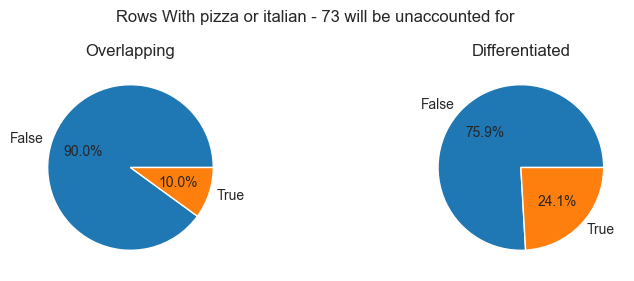

In [25]:
plot_cuisine_overlap(("pizza", "italian"))

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/1966923780.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difference = or_condition[1] - and_condition[1]


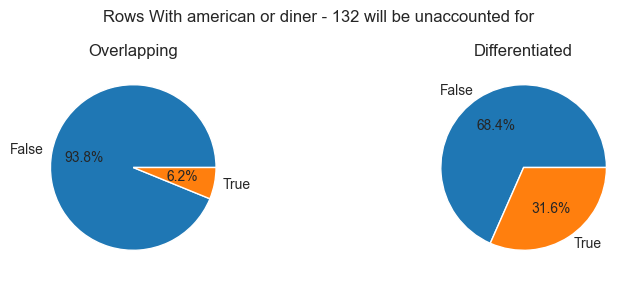

In [26]:
plot_cuisine_overlap(("american", "diner"))

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/1966923780.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difference = or_condition[1] - and_condition[1]


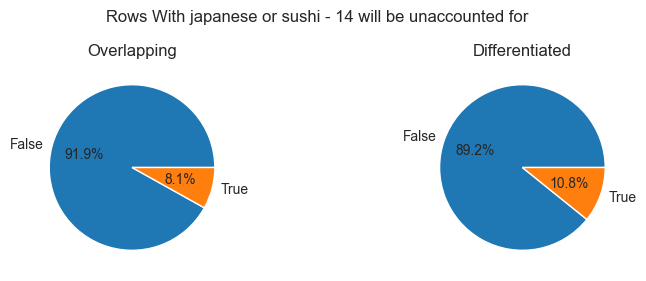

In [27]:
plot_cuisine_overlap(("japanese", "sushi"))

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/1966923780.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difference = or_condition[1] - and_condition[1]


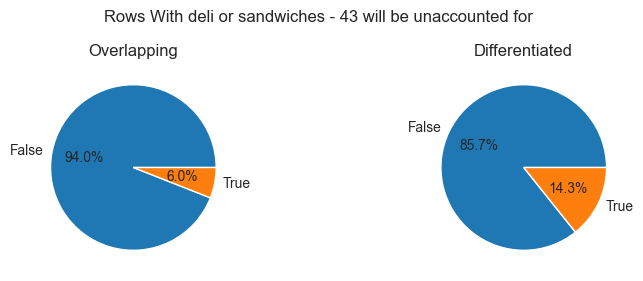

In [28]:
plot_cuisine_overlap(("deli", "sandwiches"))

### removing cuisines 
this section removes the cuisines that were found to be too similar or too confusing 

In [29]:
def remove_cuisine(l, cuisine):
    if isinstance(l, list):
        new_list = []
        for i in l:
            if i != cuisine: 
                new_list.append(i)
        if new_list != []:
            return new_list 
        else:
            return np.nan

In [30]:
# "deli", "deli food"
categories_for_removal = ["cafe", "seafood", "asian", "bar", "bar food", "latin american", "burgers", ]
for category in categories_for_removal:
    remove_category = lambda x: remove_cuisine(x, category)
    full_combo["Cuisine"] = full_combo["Cuisine"].apply(remove_category)

### Question 1 - Cuisine Dataset EDA

In [31]:
full_combo["Cuisine Type Count"] = full_combo["Cuisine"].apply(lambda l: len(l) if isinstance(l, list) else 0)
full_combo["Cuisine"] = full_combo.apply(lambda row: None if row["Cuisine Type Count"] == 0 else row["Cuisine"], axis=1 )

In [32]:
## cuisine name frequencies 
def find_cuisine_frequency(df):
    menu_freq = {}
    for cuisine_list in df["Cuisine"]: 
        if isinstance(cuisine_list, list):
            for cuisine in cuisine_list:
                if cuisine in menu_freq:
                    menu_freq[cuisine] += 1
                else:
                    menu_freq[cuisine] = 1
    return pd.DataFrame.from_dict(menu_freq, orient='index')

In [33]:
cuisine_freq = find_cuisine_frequency(full_combo)
cuisine_freq.reset_index(inplace=True)
cuisine_freq.columns = ["Cuisine", "Frequency"]
cuisine_freq.sort_values(["Frequency"], ascending = False, inplace=True)
cuisine_freq.reset_index(drop=True, inplace=True)
print("\n Cuisine Name Frequencies \n")
cuisine_freq


 Cuisine Name Frequencies 



,Cuisine,Frequency
0,american,152
1,italian,95
2,pizza,82
3,sandwiches,66
4,chinese,57
...,...,...
89,pretzels,1
90,south american,1
91,brazilian,1
92,lebanese,1


<function matplotlib.pyplot.show(close=None, block=None)>

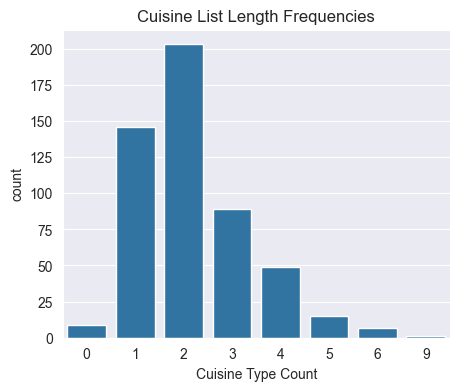

In [34]:
# cuisine list lengths 
plt.figure(figsize=(5,4))
cuisine_count = full_combo["Cuisine Type Count"].value_counts()
sns.barplot(x = cuisine_count.index, y = cuisine_count)
plt.title("Cuisine List Length Frequencies")
plt.show

## Question 2 - Finding the Cuisine Category
As the lists are an accumulation of several sources: restaurant name, Trip Advisor, Menu Data, and Inspection Data, they can be somewhat confusing to make a specific recommendation. 

For example, "3 Guys Restaurant" is described as [American, Cafe, Japanese, Diner] - while the menu items are similar to: cereal, spinach omelette, belgian waffle nutella. One of the cuisine descriptors is not appropriate - namely, "Japanese".  

The minimization will be following the assumption that the rarest cuisine is the most relevant one to the description - for example, a Mexican-Korean fusion restaurant will show up as ["Mexican", "Korean"] will be considered "Korean" if count("Mexican") > count("Korean"). Many examples from the dataset include combinations of cuisnies where this designation will be more accurate - such as ["American", "Burgers"], ["Burgers, "Sandwiches"], ["Deli Foods", "Eastern European"] - where either designation would be alright. 


### Training based on single-item lists (POC) 

In this task, the word2vec model will be tested on a relatively simple task - finding similarities between cuisines based on menu items, in a case where each menu is categorized as one specific cuisine. Since this is just a POC to make sure world knowledge/intuition corresponds to the model's results in the simple case, this run will not include a train-test phase (essentially, just training).  
The issue with this dataset is that the categorization can be somewhat unreliable - a restaurant could be listed as 2 or more categories for marketing purposes, of which only one or two are actually relevant for our use. Without creating a manually-tagged dataset, this task falls somewhere between supervised and unsupervised learning. As such, the training was broken into two steps: the first is essentially equivalent to supervised learning, but the second is closer to unsupervised learning. 
This step is important in order to better train and interpret the unsupervised case: 
- establishes a threshold for inclusion in the training set
- establishes expected points of similarity between cuisines, and between cuisines and "marker dishes" (dishes that would be a strong signal for the restaurant to belong to a specific cuisine)
- establishes a threshold for equivalent cuisines (e.g. american/diner) and fusion cuisines (e.g. american/mexican)  

In [35]:
inclusion_threshold = 5

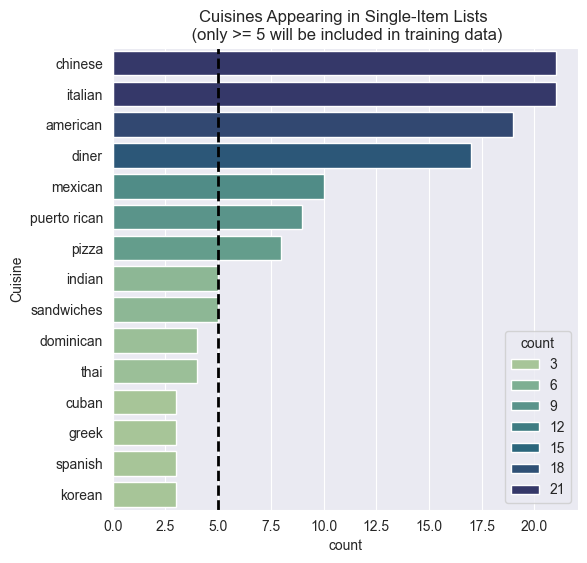

In [36]:
single_cuisine_counts = full_combo["Cuisine"][full_combo["Cuisine Type Count"] == 1].value_counts()
visual = pd.DataFrame(single_cuisine_counts)
visual.reset_index(inplace=True)
visual = visual.nlargest(15, columns=["count"])
visual["Cuisine"] = visual["Cuisine"].apply(lambda l: l[0])
plt.figure(figsize=(6,6))
sns.barplot(x = visual["count"], y = visual["Cuisine"], hue = visual["count"], palette="crest")
plt.title(f"Cuisines Appearing in Single-Item Lists \n (only >= {inclusion_threshold} will be included in training data)")
plt.axvline(x=inclusion_threshold, color='black', linestyle='--', linewidth=2)
plt.show()

### dd line here

In [37]:
single_cuisines = list(single_cuisine_counts[single_cuisine_counts >= inclusion_threshold].index)
# single_cuisines

In [38]:
full_combo["Single Cuisine"] = full_combo["Cuisine"].apply(lambda x: x in single_cuisines)
td_single_cuisine = full_combo[["Name", "Items", "Cuisine"]][full_combo["Single Cuisine"]]
print(f"there are {len(td_single_cuisine)} items in this data set")
# td_single_cuisine

there are 115 items in this data set


In [39]:
## using this data alone, how many of the menus will be covered? in other words, how many of the restaurants will have at least one label apply to them? 
def cuisine_row_coverage(cuisine_list, included_cuisines): 
    coverage = False
    if isinstance(cuisine_list, list):
            
        for i in included_cuisines:
            if isinstance(i, list):
                if i[0] in cuisine_list:
                    coverage = True
            elif isinstance(i, str):
                if i in cuisine_list:
                    coverage = True
        return coverage

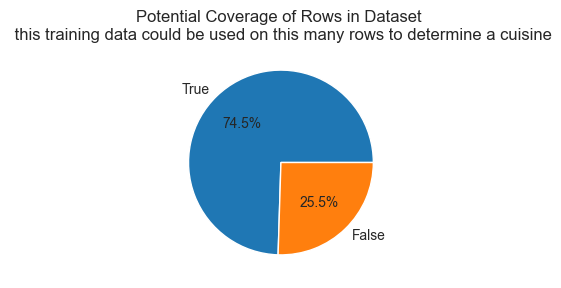

In [40]:
full_combo["Training Coverage"] = full_combo["Cuisine"].apply(lambda l: cuisine_row_coverage(l, single_cuisines))
training_coverage = full_combo["Training Coverage"].value_counts(normalize=True)
plt.figure(figsize=(3,3))
plt.pie(training_coverage, labels=training_coverage.index, autopct='%1.1f%%', colors = sns.color_palette("tab10"))
plt.title("Potential Coverage of Rows in Dataset \n this training data could be used on this many rows to determine a cuisine")
plt.show()

In a previous iteration, setting the threshold point at 3 examples was too low - while the coverage would have been higher (about three quarters of all the rows compared to 62% when the threshold is set at 5) - the model could not capture the similarity/difference between restaurants in cuisines with only 3 examples. The cuisine names themselves were added to the training data to make sure we can later use the cosine similarity when assessing if two cuisines are similar.    

In [41]:
td_single_cuisine["training data - word2vec"] = td_single_cuisine["Cuisine"] + td_single_cuisine["Items"]
model = Word2Vec(sentences = td_single_cuisine["training data - word2vec"], vector_size=500)
model.train(td_single_cuisine["training data - word2vec"], total_examples=len(td_single_cuisine["training data - word2vec"]), epochs=100)

(517801, 2315400)

#### reviewing model results

In [42]:
# sanity check - some cosine similarity tests

# similarities = [("soda", "juice"), ("egg roll", "burrata")]
# for item in similarities:
#     print(f"the similarity of {item} is {model.wv.similarity(item[0], item[1])}")

#### menu item coverage

In [43]:
def run_on_all_variations(item):
    item_variations = []
    item_words = item.split()
    for i in range(len(item_words)):
        item_variations.append(item_words[i])
        if i < len(item_words) - 1:
            for j in range(i + 1, len(item_words) + 1):
                item_section = " ".join(item_words[i:j])
                item_variations.append(item_section)
    return item_variations

In [44]:
### coverage 
def term_coverage(df, column, raw = False):
    ## input: dataframe & column to be compared against last trained model.
    ## output: dataframe with the coverage data.
    
    raw_coverage = {}
    term_coverage = {}
    
    for menu in df[column]:
        for item in menu: 
                item_variations = run_on_all_variations(item)
                term_covered =  False
                for variation in item_variations:
                    if variation not in raw_coverage:
                        if model.wv.has_index_for(variation):
                            raw_coverage[variation] = True
                            term_covered = True
                        else:
                            raw_coverage[variation] = False
                term_coverage[item] = term_covered
    if raw: 
        return pd.DataFrame.from_dict(raw_coverage, orient='index')
    else:
        return pd.DataFrame.from_dict(term_coverage, orient='index')

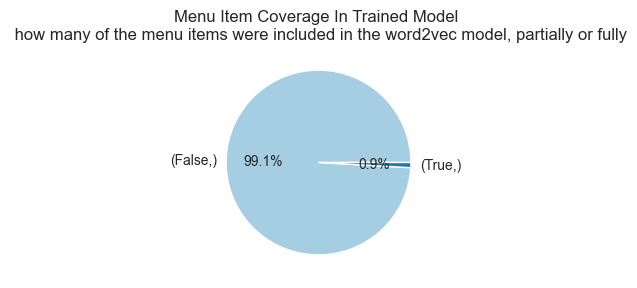

In [45]:
coverage_summary = term_coverage(td_single_cuisine, "Items").value_counts(normalize=True)
plt.figure(figsize=(3,3))
plt.pie(coverage_summary, labels=coverage_summary.index, autopct='%1.1f%%', colors = sns.color_palette("Paired"))
plt.title("Menu Item Coverage In Trained Model \n how many of the menu items were included in the word2vec model, partially or fully")
plt.show()

#### similarities - menu items & cuisines 

In [46]:
def find_cuisne_terms(df):
    cuisine_terms = {}
    for cuisine in list(df["Cuisine"].apply(lambda l: l[0])):
        cuisine_terms[cuisine] = []
        for row in df.iterrows():
            if row[1][2] == [cuisine]:
                for i in row[1][1]:
                    if model.wv.has_index_for(i):
                        if i not in cuisine_terms[cuisine]:
                            cuisine_terms[cuisine].append(i)
                            
    return cuisine_terms

single_cuisine_terms = find_cuisne_terms(td_single_cuisine)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/2002180089.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][2] == [cuisine]:
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/2002180089.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in row[1][1]:


In [47]:
# creating a table that contains an item and its most similar item as found by the model - this is helpful in establishing a threshold for the lowest number of restaurants belonging to a cuisine that are necessary to get proper results from the model. In this case, results for 3 examples were not reliable, while results for at least 5 examples were decent. That means that in the next step, at least 5 menus from each cuisine will be necessary in order to train the model. 
most_similar_items = {}
counter = 0
for cuisine in single_cuisine_terms:
    cuisine_size = int(visual["count"].loc[visual["Cuisine"] == cuisine])
    most_similar_items[counter] = [cuisine, cuisine_size, cuisine, model.wv.most_similar(cuisine)[0][0]]
    counter += 1
    for term in single_cuisine_terms[cuisine]:
        most_similar_items[counter] = [cuisine, cuisine_size, term, model.wv.most_similar(term)[0][0]]
        counter += 1

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_97382/1881148017.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cuisine_size = int(visual["count"].loc[visual["Cuisine"] == cuisine])


In [48]:
 print("\n Item Markers for Cuisines:  \n these items serve as an indication that the trained model makes sense. Visualization to follow \n")
most_similar_items_df = pd.DataFrame.from_dict(most_similar_items, orient='index')
most_similar_items_df.columns = ["Cuisine", "Cuisine Size", "Item", "Most Similar Item"]
most_similar_items_df.loc[most_similar_items_df["Cuisine"] == most_similar_items_df["Item"]]


 Item Markers for Cuisines:  
 these items serve as an indication that the trained model makes sense. Visualization to follow 



,Cuisine,Cuisine Size,Item,Most Similar Item
0,chinese,21,chinese,vegetable roll
221,puerto rican,9,puerto rican,malta
322,indian,5,indian,vegetable soup
338,sandwiches,5,sandwiches,egg sandwich
434,american,19,american,classic caesar salad
684,italian,21,italian,bruschetta
801,mexican,10,mexican,flautas
875,diner,17,diner,fresh fruit platter
1209,pizza,8,pizza,garlic knots


In [49]:
def generate_most_similar_table(terms):
    tables = []
    for i in terms:
        df = pd.DataFrame(model.wv.most_similar(i))
        df.columns = ["item", "similarity score"]
        tables.append(df)
    return tables
egg_roll_similar, burrata_similar, nachos_similar = generate_most_similar_table(["american", "italian", "mexican"])

In [50]:
def plot_similar_menu_items(df, term, color_palette="Blues"):
    sns.barplot(data = df, x ="similarity score", y = "item", orient="h", palette=color_palette, hue="item", legend=False)
    plt.title(f"Menu Items Similar to '{term}'")
    plt.xlim(0.5, 1.0)

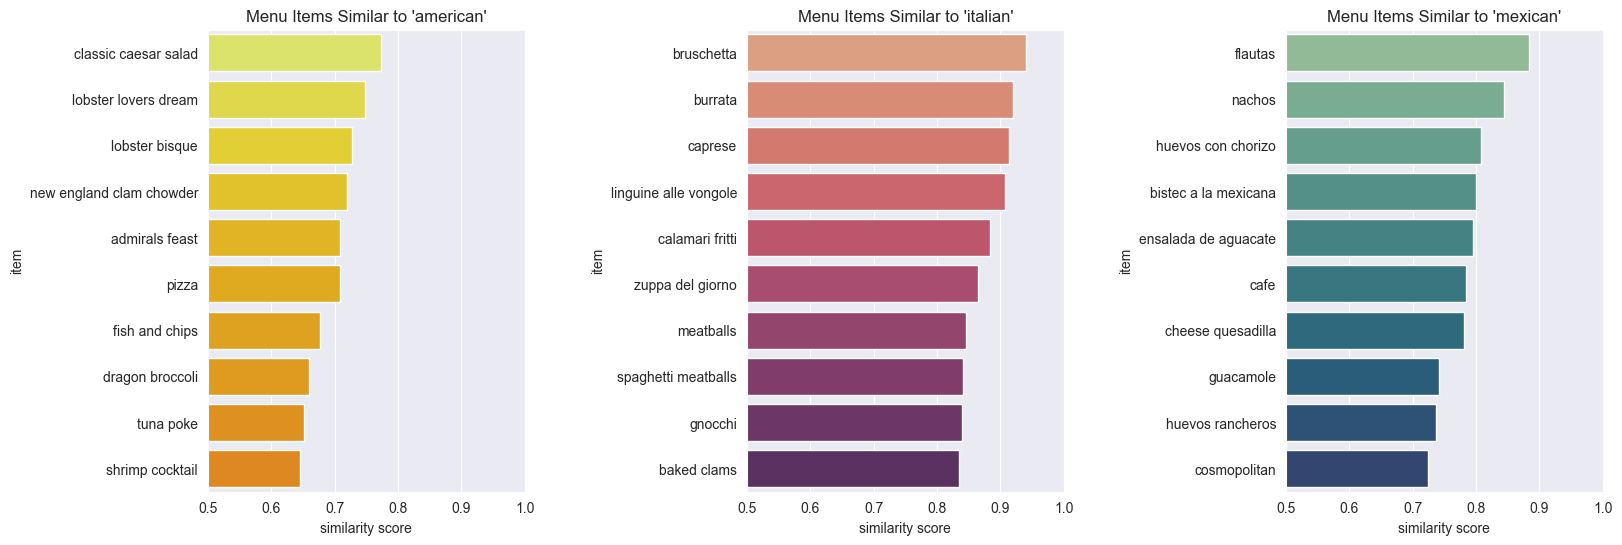

In [51]:
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_similar_menu_items(egg_roll_similar, "american", color_palette="Wistia")
plt.subplot(1, 3, 2)
plot_similar_menu_items(burrata_similar, "italian", color_palette="flare")
plt.subplot(1, 3, 3)
plot_similar_menu_items(nachos_similar, "mexican", color_palette="crest")
plt.subplots_adjust(wspace = 0.7)
plt.show()

#### similarity - between cuisines 

In [52]:
def find_cuisine_similarity(cuisine_terms):
    cuisine_similarity = {}
    counter = 0 
    for pair in list(combinations(cuisine_terms.keys(), 2)):
        similarity = model.wv.similarity(pair[0], pair[1])
        similarity = round(float(similarity) , 2)
        cuisine_similarity[counter] = [pair[0], pair[1], similarity]
        counter += 1
    cuisine_similarity_df = pd.DataFrame.from_dict(cuisine_similarity, orient='index')
    cuisine_similarity_df.columns = ["Cuisine 1", "Cuisine 2", "Similarity Score"]
    cuisine_similarity_df.sort_values(by="Similarity Score", ascending=False, inplace=True)
    return cuisine_similarity_df

In [53]:
cuisine_similarity_df = find_cuisine_similarity(single_cuisine_terms)
cuisine_similarity_df

,Cuisine 1,Cuisine 2,Similarity Score
29,american,pizza,0.71
32,italian,pizza,0.67
1,chinese,indian,0.64
26,american,italian,0.58
33,mexican,diner,0.50
12,puerto rican,mexican,0.48
20,indian,pizza,0.46
34,mexican,pizza,0.43
8,puerto rican,indian,0.42
0,chinese,puerto rican,0.41


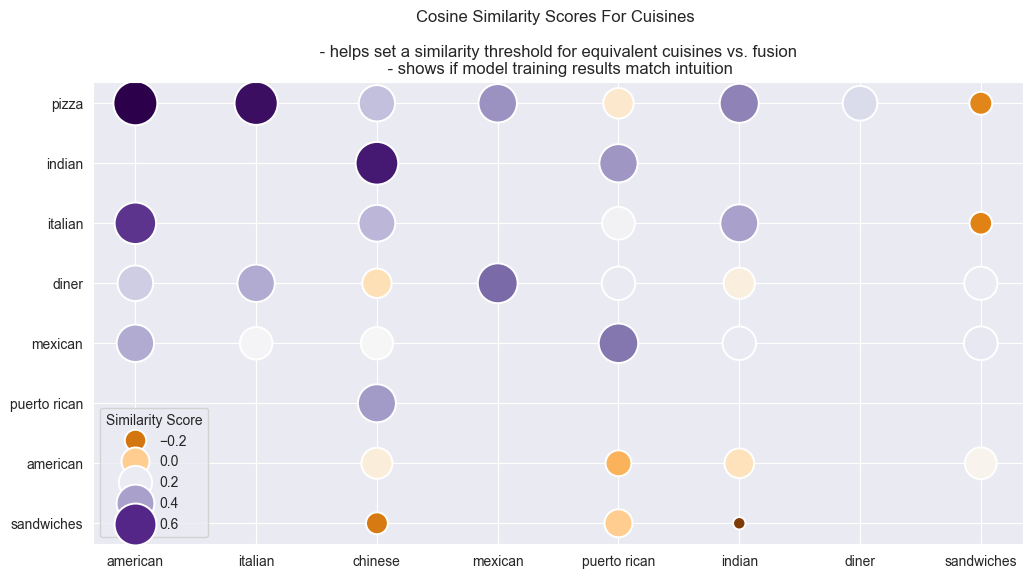

In [54]:
def generate_cuisine_similarity_plot(df):
    sns.scatterplot(data = df, x = "Cuisine 1", y = "Cuisine 2", size = "Similarity Score", hue = "Similarity Score",  palette="PuOr", sizes = (80,1000))
    plt.xlabel("")
    plt.ylabel("")
plt.figure(figsize=(12,6))
generate_cuisine_similarity_plot(cuisine_similarity_df)
plt.title("Cosine Similarity Scores For Cuisines \n \n - helps set a similarity threshold for equivalent cuisines vs. fusion \n - shows if model training results match intuition")
plt.show()

### Model Training on Longer Lists

This section is focused on the training of a word2vec in a way that will be usable for the prediction task. 
When training on up to 3-item cuisine lists, the results of the unsupervised training are consistent, intuitive, and cover approx. 85% of the rows in the dataset.  
When training on up to 2-item cuisine lists, the results start to become inconsistent with previous results and with intuition when the inclusion threshold is too small, but when it is larger - coverage is lost, staying at ~80%.
There seems to no significant gain in applying training on 3-item lists - therefore, the model trained on up to 3-item lists will be the choice applied here. 

It should be noted that the model can - and should - be improved: this can be done by cleaning the menu item lists further, removing all generic drinks, removing some generic terminology (e.g. portion sizes) etc.; at the moment, this is not a priority, as the data can be cleaned to tweak the model ad infinitum. The current results seem to be sufficient for the task at hand - a basic POC - so this process will stop at this point, unless found to be necessary at a later point in time.

In [120]:
inclusion_threshold = 13
max_items_in_cuisine_list = 3
# inclusion_threshold = 10
# max_items_in_cuisine_list = 2
# inclusion_threshold = 15
# max_items_in_cuisine_list = 4

In [121]:
one_or_two_cuisine_counts = find_cuisine_frequency(full_combo[full_combo["Cuisine Type Count"] <= max_items_in_cuisine_list])
one_or_two_cuisine_counts = pd.DataFrame(one_or_two_cuisine_counts)
one_or_two_cuisine_counts.reset_index(inplace=True)
one_or_two_cuisine_counts.columns = ["Cuisine", "Counts"]
one_or_two_cuisine_counts.sort_values(by="Counts", ascending=False, inplace=True)
# one_or_two_cuisine_counts

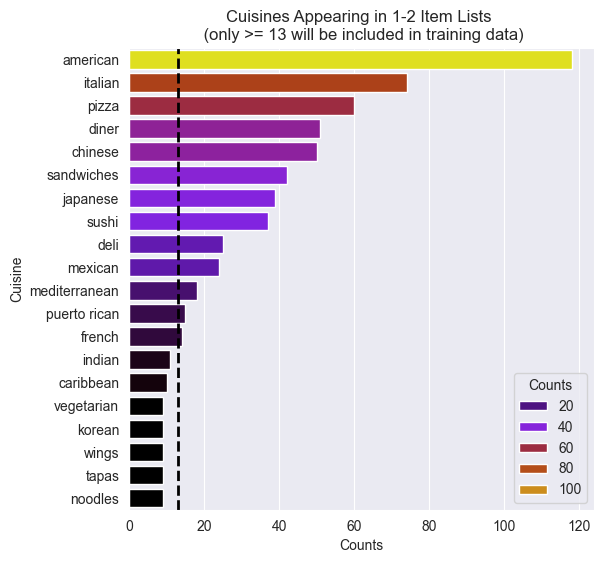

In [122]:
visual = one_or_two_cuisine_counts.nlargest(20, columns = "Counts")
plt.figure(figsize=(6,6))
sns.barplot(x = visual["Counts"], y = visual["Cuisine"], hue = visual["Counts"], palette="gnuplot")
plt.title(f"Cuisines Appearing in 1-2 Item Lists \n (only >= {inclusion_threshold} will be included in training data)")
plt.axvline(x=inclusion_threshold, color='black', linestyle='--', linewidth=2)
plt.show()

In [123]:
dual_cuisines = list(one_or_two_cuisine_counts[one_or_two_cuisine_counts["Counts"] >= inclusion_threshold]["Cuisine"])

In [124]:
def include_cuisine(included_list, cuisine_list):
    include = False
    if isinstance(cuisine_list, list):
        for potential in cuisine_list:
            if potential in included_list:
                include = True
                return include
    return include

In [125]:
td_dual_cuisines = full_combo.loc[full_combo["Cuisine Type Count"] <= max_items_in_cuisine_list]
td_dual_cuisines = td_dual_cuisines[["Name", "Items", "Cuisine"]]
td_dual_cuisines["Included"] = td_dual_cuisines["Cuisine"].apply(lambda l: include_cuisine(dual_cuisines, l))
td_dual_cuisines = td_dual_cuisines[td_dual_cuisines["Included"]]
print(f"there are {len(td_dual_cuisines)} items in this data set")
td_dual_cuisines

there are 371 items in this data set


,Name,Items,Cuisine,Included
1,251 Ginza Sushi,"[spring water and soda, snapple ice tea, bottl...","[japanese, sushi]",True
2,3 Guys Restaurant,"[cold cereal, cold cereal with banana, hot oat...","[japanese, american, diner]",True
4,5 Brothers Gourmet Deli,"[fresh homemade beef brisket sandwich, fresh t...","[sandwiches, deli, american]",True
5,5 Estrellas Bakery,"[espresso shot, cafe con leche, regular tea, c...","[smoothies juices, sandwiches, bakery pastries]",True
6,5 Napkin Burger,"[i do not need utensils ketchup or, add plasti...","[contemporary, sushi, american]",True
...,...,...,...,...
790,Yakitori Totto,"[paitan ramen, pork loin don, eel don, totto d...","[japanese, tapas]",True
791,Yankee Pizza,"[large pizza, cheese pizza, classic margarita ...",[pizza],True
792,Yaya Tea,"[octopus takoyaki appetizer, crab meat ricebal...",[japanese],True
798,il Buco,"[olive, salumi, croquettas, burrata, polpo, cr...",[italian],True


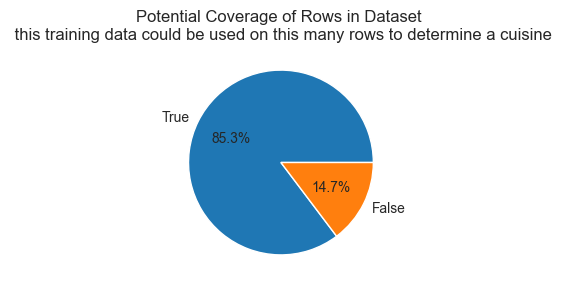

In [126]:
full_combo["Training Coverage"] = full_combo["Cuisine"].apply(lambda l: cuisine_row_coverage(l, dual_cuisines))
training_coverage = full_combo["Training Coverage"].value_counts(normalize=True)
plt.figure(figsize=(3,3))
plt.pie(training_coverage, labels=training_coverage.index, autopct='%1.1f%%', colors = sns.color_palette("tab10"))
plt.title("Potential Coverage of Rows in Dataset \n this training data could be used on this many rows to determine a cuisine")
plt.show()

In [127]:
td_dual_cuisines = td_dual_cuisines.dropna(subset=["Cuisine"])
td_dual_cuisines["training data - word2vec"] = td_dual_cuisines["Cuisine"] + td_dual_cuisines["Items"]
model = Word2Vec(sentences = td_dual_cuisines["training data - word2vec"], vector_size=2000)
model.train(td_dual_cuisines["training data - word2vec"], total_examples=len(td_dual_cuisines["training data - word2vec"]), epochs=100)

(2689361, 7841700)

#### model coverage of menu items

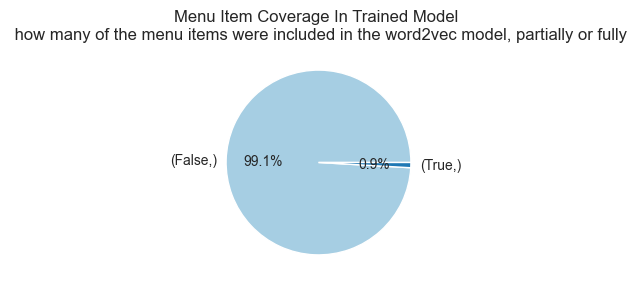

In [128]:
coverage_summary = term_coverage(td_dual_cuisines, "Items").value_counts(normalize=True)
plt.figure(figsize=(3,3))
plt.pie(coverage_summary, labels=coverage_summary.index, autopct='%1.1f%%', colors = sns.color_palette("Paired"))
plt.title("Menu Item Coverage In Trained Model \n how many of the menu items were included in the word2vec model, partially or fully")
plt.show()

#### similarirty - cuisines and items

In [129]:
def find_most_similar_items(df, included_cuisines, only_cuisines = True, only_terms = False): 
    most_similar_items = {}
    cuisine_terms = {}
    counter = 0
    
    def add_items_to_cuisine_terms(cuisine, item_list):
        for item in item_list:
            if item not in cuisine_terms: 
                cuisine_terms[cuisine].append(item)
            
    for cuisine in included_cuisines:
        cuisine_terms[cuisine] = []
        cs = visual["Counts"].loc[visual["Cuisine"] == cuisine]
        if len(cs) == 1:
            cuisine_size = int(cs.iloc[0])
        most_similar_items[counter] = [cuisine, cuisine_size, cuisine, model.wv.most_similar(cuisine)[0][0]]
        counter += 1
        if only_terms or not only_cuisines:
            df.apply(lambda row: add_items_to_cuisine_terms(cuisine, row["Items"]) if cuisine in row["Cuisine"] else None, axis = 1)
            if not only_cuisines:
                for term in cuisine_terms[cuisine]:
                    if model.wv.has_index_for(term):
                        most_similar_items[counter] = [cuisine, cuisine_size, term, model.wv.most_similar(term)[0][0]]
                        counter += 1
    most_similar_items_df = pd.DataFrame.from_dict(most_similar_items, orient='index')
    most_similar_items_df.columns = ["Cuisine", "Cuisine Size", "Item", "Most Similar Item"]
    if only_terms:
        return cuisine_terms
    return most_similar_items_df
            

In [130]:
print(
    "\n Item Markers for Cuisines:  \n these items serve as an indication that the trained model makes sense. Visualization to follow \n")
find_most_similar_items(td_dual_cuisines, dual_cuisines)


 Item Markers for Cuisines:  
 these items serve as an indication that the trained model makes sense. Visualization to follow 



,Cuisine,Cuisine Size,Item,Most Similar Item
0,american,118,american,spinach artichoke dip
1,italian,74,italian,caprese
2,pizza,60,pizza,calamari fritti
3,diner,51,diner,melon with cottage cheese
4,chinese,50,chinese,spring roll
5,sandwiches,42,sandwiches,deli
6,japanese,39,japanese,sushi
7,sushi,37,sushi,japanese
8,deli,25,deli,sandwiches
9,mexican,24,mexican,huevos a la mexicana


In [131]:
italian, american, chinese, pizza, deli , mexican = generate_most_similar_table(["italian", "american", "chinese", "pizza", "deli", "mexican"])

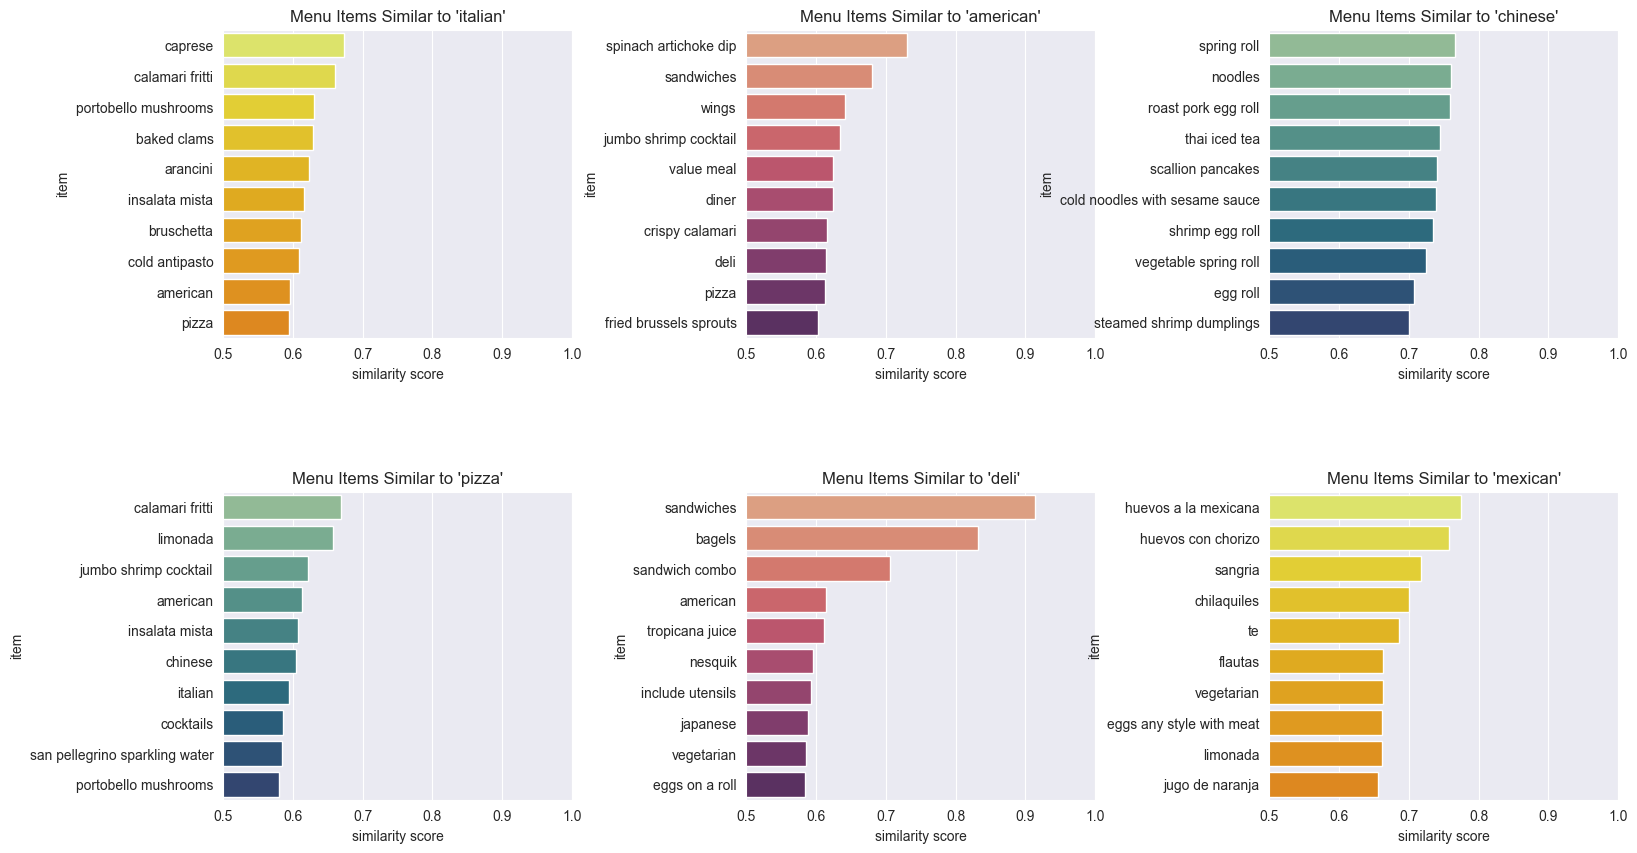

In [132]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plot_similar_menu_items(italian, "italian", color_palette="Wistia")
plt.subplot(2, 3, 2)
plot_similar_menu_items(american, "american", color_palette="flare")
plt.subplot(2, 3, 3)
plot_similar_menu_items(chinese, "chinese", color_palette="crest")
plt.subplot(2, 3, 4)
plot_similar_menu_items(pizza, "pizza", color_palette="crest")
plt.subplot(2, 3, 5)
plot_similar_menu_items(deli, "deli", color_palette="flare")
plt.subplot(2, 3, 6)
plot_similar_menu_items(mexican, "mexican", color_palette="Wistia")

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [133]:
dual_cuisine_terms = find_most_similar_items(td_dual_cuisines, dual_cuisines, only_terms = True)
cuisine_similarity_df = find_cuisine_similarity(dual_cuisine_terms)
# cuisine_similarity_df

In [134]:
cuisine_similarity_df.head(15)

,Cuisine 1,Cuisine 2,Similarity Score
52,sandwiches,deli,0.91
57,japanese,sushi,0.87
4,american,sandwiches,0.68
48,chinese,puerto rican,0.64
2,american,diner,0.62
7,american,deli,0.61
49,chinese,french,0.61
1,american,pizza,0.61
0,american,italian,0.60
76,mediterranean,french,0.60


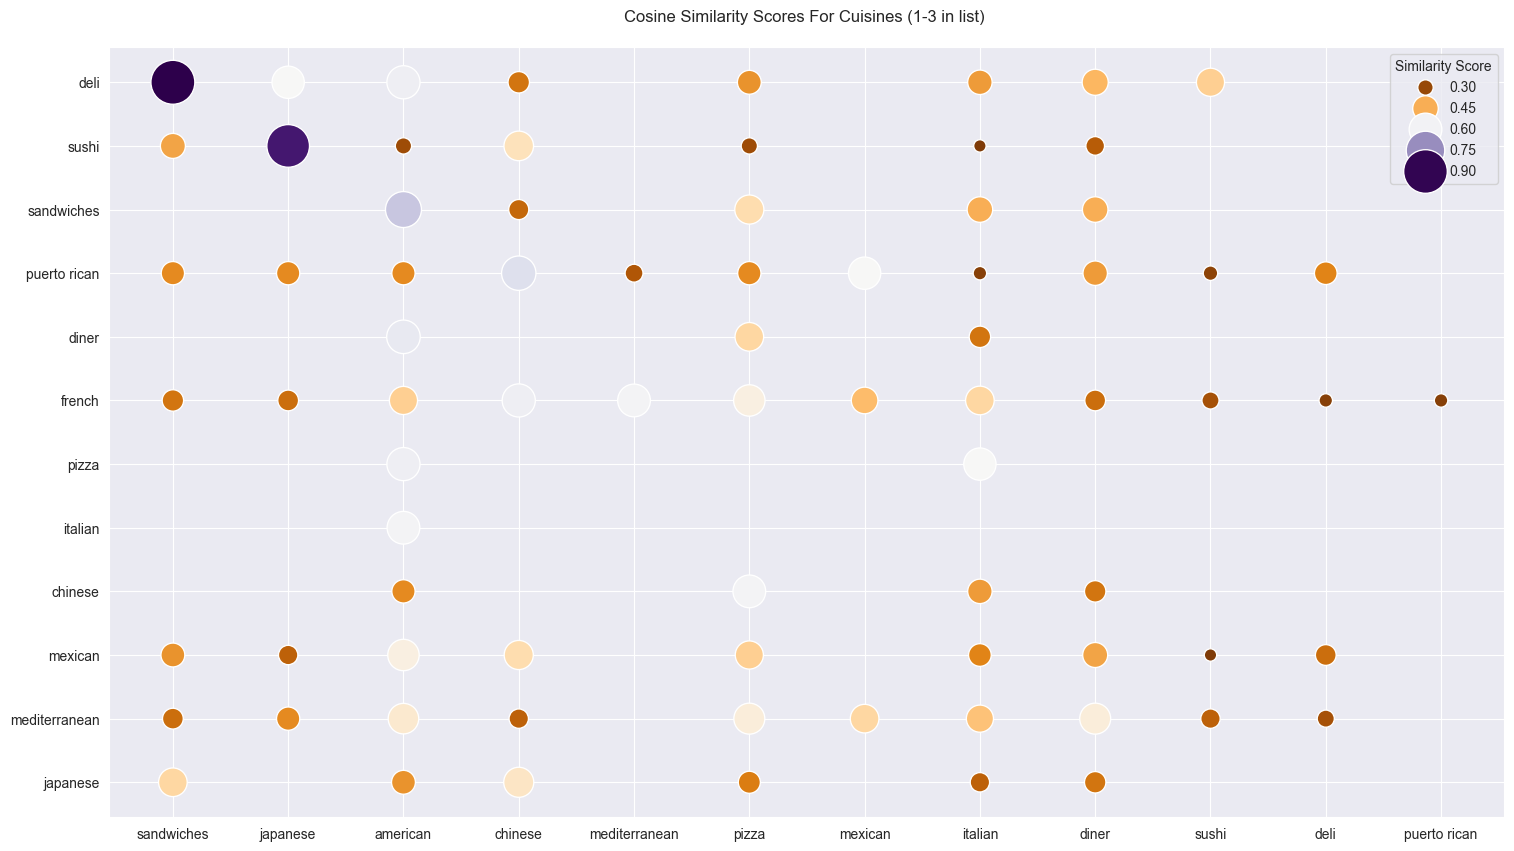

In [135]:
plt.figure(figsize=(18,10))
generate_cuisine_similarity_plot(cuisine_similarity_df)
plt.title(f"Cosine Similarity Scores For Cuisines (1-{max_items_in_cuisine_list} in list) \n")
plt.show()